In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff                             
import matplotlib.pyplot as plt

# hepatitis data load and convert to array
data_hepatitis=pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data" , header=None)
data_hepatitis=data_hepatitis.to_numpy()

# diabeties load data and convert to array
data_diabetes = arff.loadarff('messidor_features.arff')
data_diabetes = pd.DataFrame(data_diabetes[0])
data_diabetes=data_diabetes.to_numpy()

In [ ]:
class cleaning:

    def __init__(self,data):
        self.data=data
        return
    
    def type_data_miss (self,tp=1):
        self.tp=tp
        if tp==1:
            self.missing=np.equal(self.data,"?")
            
        elif tp==2:
            self.missing=np.equal(self.data[:,0],0)
            self.missing=np.transpose([np.transpose(self.missing)]*20)
        return self
    
    
    def column_clean(self,trsh=1):
        miss=[]
        for i in range(self.data.shape[1]):
            num_non=sum(self.missing[:,i])
            if num_non>trsh*self.data.shape[0]:
                miss.append(i)
        self.data=np.delete(self.data, miss, 1)
        self.missing=np.delete(self.missing, miss, 1)
        return self
    
    
    def row_clean(self,trsh=1):
        miss=[]
        for i in range(self.data.shape[0]):
            num_non=sum(self.missing[i,:])
            if num_non>trsh*self.data.shape[1]:
                miss.append(i)
        self.data=np.delete(self.data, miss, 0)
        self.missing=np.delete(self.missing, miss, 0)
        return self

    def data_derivation(self):
        perfect_data_rindex=[]
        incomplete_realdata_index=[]
        incomplete_predictdata_index=[]
        
        for i in range(self.data.shape[0]):
            num_non=sum(self.missing[i,:])
            if num_non==0:
                perfect_data_rindex.append(i)
            else:
                incomplete_realdata_index.append([])
                incomplete_predictdata_index.append([])
                for j in range(self.data.shape[1]):
                    if self.missing[i,j]:
                        incomplete_predictdata_index[len(incomplete_realdata_index)-1].append([i,j])
                    else:
                        incomplete_realdata_index[len(incomplete_realdata_index)-1].append([i,j])

        for i in range(len(incomplete_realdata_index)):
            dist_predict=[]
            for j in perfect_data_rindex:
                dist=0
                for k in range(len(incomplete_realdata_index[i])):
                    dist=dist+(float(self.data[j,incomplete_realdata_index[i][k][1]])-float(self.data[incomplete_realdata_index[i][k][0],incomplete_realdata_index[i][k][1]]))**2
                dist_predict.append(dist)
            m_list=min(dist_predict)
            ind=dist_predict.index(m_list)
            
            for l in range(len(incomplete_predictdata_index[i])):
                self.data[incomplete_predictdata_index[i][l][0],incomplete_predictdata_index[i][l][1]]=self.data[perfect_data_rindex[ind],incomplete_predictdata_index[i][l][1]]
        return self

    
    def best_correlation(self,num_f):
        variance=np.var(self.data.astype(float) , axis=0)
        columns=np.arange(self.data.shape[1])
        for i in range(0,len(variance)):
            if variance[i]==0:
                self.data=np.delete(self.data, columns[i], 1)
        data_df=pd.DataFrame(self.data).astype(float)
        data_correlation=data_df.corr(method='pearson').abs()
        if self.tp==1:
            clm=0
        else:
            clm=data_df.shape[1]-1
        target_correlation=data_correlation[clm]
        target_correlation=target_correlation.sort_values(ascending=False)
        data_indices=target_correlation.index
        cleaning_indices=[]
        cleaning_indices.append([data_indices[1],target_correlation[data_indices[1]]])
        
        for f in range(1,num_f):
            corr=0
            for i in range(len(cleaning_indices)+1,len(target_correlation)):
                c_test=1
                aa=target_correlation[data_indices[i]]
                for j in range(len(cleaning_indices)):
                    dc=data_correlation[data_indices[i]][cleaning_indices[j][0]]
                    c_test=c_test*(1-dc)
                c_test=c_test*aa
                if c_test>corr:
                    corr=c_test
                    ind=data_indices[i]
            cleaning_indices.append([ind,corr])
        df=pd.DataFrame(cleaning_indices)
        df=df.sort_values(by=[1])
        self.data=np.delete(self.data, df[0][0:data_indices.size-num_f], 1)
        return self
    
    def give_data(self):
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                self.data[i][j]=float(self.data[i][j])
        return self.data

def normalization( x_t):
    for i in range(x_t.shape[1]):
        max_f=max(x_t[:,i])
        x_t[:,i]=x_t[:,i]/max_f
    return x_t
       
# cleaning hepatitis data
num_features_hpt=10                                                             # specifies number of features we want to have after cleaning data
hepatitis=cleaning(data_hepatitis)
data_hpt=hepatitis.type_data_miss(tp=1).column_clean(trsh=0.1).row_clean(trsh=0.1).data_derivation().give_data()
data1=pd.DataFrame(data_hpt)
aaaa=data1.cov()
y_hpt, x_hpt = data_hpt[:,0].astype(int), data_hpt[:,1:num_features_hpt]
y_hpt=y_hpt-1
(N_hpt,D_hpt), C_hpt = x_hpt.shape, np.max(y_hpt)+1
np.random.seed(1674)
inds_hpt = np.random.permutation(N_hpt)
x_hpt=normalization(x_hpt)
x_train_hpt, y_train_hpt = x_hpt[inds_hpt[:100]], y_hpt[inds_hpt[:100]]
x_test_hpt, y_test_hpt = x_hpt[inds_hpt[100:]], y_hpt[inds_hpt[100:]]
# print(f'hepatitis instances (N) \t {N_hpt} \n hepatitis features (D) \t {D_hpt} \n hepatitis classes (C) \t {C_hpt}')

# cleaning diabet data
num_features_dbt=10                                                             # specifies number of features we want to have after cleaning data
diabet=cleaning(data_diabetes)
data_dbt=diabet.type_data_miss(tp=2).row_clean(trsh=0.1).best_correlation(num_f=num_features_dbt).give_data()

# creating test and train set for diabetes
y_dbt, x_dbt = data_dbt[:,num_features_dbt-1].astype(int), data_dbt[:,0:num_features_dbt-1]
(N_dbt,D_dbt), C_dbt = x_dbt.shape, np.max(y_dbt)+1 
np.random.seed(1334)
inds_dbt = np.random.permutation(N_dbt)                                                     
x_dbt=normalization(x_dbt)

x_train_dbt, y_train_dbt = x_dbt[inds_dbt[:770]], y_dbt[inds_dbt[:770]]
x_test_dbt, y_test_dbt = x_dbt[inds_dbt[770:]], y_dbt[inds_dbt[770:]]
# print(f'diabetes instances (N) \t {N_dbt} \n diabetes features (D) \t {D_dbt} \n diabetes classes (C) \t {C_dbt}')

# %%

euclidean = lambda x1, x2: np.sqrt(np.float32(np.sum((x1 - x2)**2,axis = -1)))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
minkovski = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

In [ ]:
def accuracy(x_test, y_test, y_pred):
  accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
  TP1=np.where(y_test==1 )
  TP2=np.where(y_pred == y_test)
  TP=np.intersect1d(TP1,TP2)
  FN1=np.where(y_test==1 )
  FN2=np.where(y_pred==0 )
  FN=np.intersect1d(FN1,FN2)
  FP1=np.where(y_test==0 )
  FP2=np.where(y_pred==1 )
  FP=np.intersect1d(FP1,FP2)
  TN1=np.where(y_test==0 )
  TN2=np.where(y_pred==0 )
  TN=np.intersect1d(TN1,TN2)
  recall = TP.shape[0]/(FN.shape[0]+TP.shape[0]+0.001)
  precision=TP.shape[0]/(FP.shape[0]+TP.shape[0]+0.001)
  Selectivity=TN.shape[0]/(TN.shape[0]+FP.shape[0]+0.001)
  N_predictive_v=TN.shape[0]/(TN.shape[0]+FN.shape[0]+0.001)
  return accuracy,recall,precision,Selectivity,N_predictive_v

In [ ]:
# KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# heptatitis
for i in range(1, 2):
  model = KNeighborsClassifier(n_neighbors=i)
  model.fit(x_train_hpt, y_train_hpt)
  y_pred_hpt = model.predict(x_test_hpt)
  acc_hpt,recall_hpt,precision_hpt,Selectivity_hpt,N_predictive_v_hpt = accuracy(x_test_hpt, y_test_hpt, y_pred_hpt)
  print("K =", i)
  print(f'KNN accuracy for hepatitis is {acc_hpt*100:.1f}.')
  print(f'KNN recall for hepatitis is {recall_hpt*100:.1f}.')
  print(f'KNN precision for hepatitis is {precision_hpt*100:.1f}.')
  print(f'KNN Selectivity for hepatitis is {Selectivity_hpt*100:.1f}.')
  print(f'KNN Negative predictive value for hepatitis is {N_predictive_v_hpt*100:.1f}.')

knn_acc_hpt = []
knn_k = []
for i in range(1, 16):
  knn_k.append(i)
  m = KNeighborsClassifier(n_neighbors=i)
  m.fit(x_train_hpt, y_train_hpt)
  yph = m.predict(x_test_hpt)
  acc,_,_,_,_ = accuracy(x_test_hpt, y_test_hpt, yph)
  knn_acc_hpt.append(acc)

print(knn_k, knn_acc_hpt)
print()

# diabetes
for i in range(1, 2):
  model2 = KNeighborsClassifier(n_neighbors=i)
  model2.fit(x_train_dbt, y_train_dbt)
  y_pred_dbt = model2.predict(x_test_dbt)
  acc_dbt,recall_dbt,precision_dbt,Selectivity_dbt,N_predictive_v_dbt = accuracy(x_test_dbt, y_test_dbt, y_pred_dbt)
  print("K =", i)
  print(f'KNN accuracy for diabetes is {acc_dbt*100:.1f}.')
  print(f'KNN recall for diabetes is {recall_dbt*100:.1f}.')
  print(f'KNN precision for diabetes is {precision_dbt*100:.1f}.')
  print(f'KNN Selectivity for diabetes is {Selectivity_dbt*100:.1f}.')
  print(f'KNN Negative predictive value for diabetes is {N_predictive_v_dbt*100:.1f}.')

knn_acc_dbt = []
for i in range(1, 16):
  m2 = KNeighborsClassifier(n_neighbors=i)
  m2.fit(x_train_dbt, y_train_dbt)
  ypd = m2.predict(x_test_dbt)
  acc,_,_,_,_ = accuracy(x_test_dbt, y_test_dbt, ypd)
  knn_acc_dbt.append(acc)

print(knn_k, knn_acc_dbt)

K = 1
KNN accuracy for hepatitis is 69.8.
KNN recall for hepatitis is 80.0.
KNN precision for hepatitis is 82.4.
KNN Selectivity for hepatitis is 25.0.
KNN Negative predictive value for hepatitis is 22.2.
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] [0.6976744186046512, 0.6046511627906976, 0.6511627906976745, 0.5813953488372093, 0.6976744186046512, 0.627906976744186, 0.6744186046511628, 0.627906976744186, 0.627906976744186, 0.6511627906976745, 0.6511627906976745, 0.6976744186046512, 0.6976744186046512, 0.6976744186046512, 0.6976744186046512]

K = 1
KNN accuracy for diabetes is 60.5.
KNN recall for diabetes is 57.4.
KNN precision for diabetes is 62.9.
KNN Selectivity for diabetes is 63.7.
KNN Negative predictive value for diabetes is 58.3.
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] [0.6047745358090185, 0.6047745358090185, 0.6127320954907162, 0.6206896551724138, 0.623342175066313, 0.6419098143236074, 0.6339522546419099, 0.6472148541114059, 0.6339522546419099, 0.6259946949

In [ ]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

# hepatitis
model = DecisionTreeClassifier(criterion="gini", max_depth=2)
model.fit(x_train_hpt, y_train_hpt)
y_pred_hpt = model.predict(x_test_hpt)
acc_hpt,recall_hpt,precision_hpt,Selectivity_hpt,N_predictive_v_hpt = accuracy(x_test_hpt, y_test_hpt, y_pred_hpt)
print(f'DT accuracy for hepatitis is {acc_hpt*100:.1f}.')
print(f'DT recall for hepatitis is {recall_hpt*100:.1f}.')
print(f'DT precision for hepatitis is {precision_hpt*100:.1f}.')
print(f'DT Selectivity for hepatitis is {Selectivity_hpt*100:.1f}.')
print(f'DT Negative predictive value for hepatitis is {N_predictive_v_hpt*100:.1f}.')

dt_depth = []
dt_acc_hpt = []
for i in range(1, 16):
  dt_depth.append(i)
  m = DecisionTreeClassifier(max_depth=i)
  m.fit(x_train_hpt, y_train_hpt)
  yph = m.predict(x_test_hpt)
  acc,_,_,_,_ = accuracy(x_test_hpt, y_test_hpt, yph)
  dt_acc_hpt.append(acc)
print(dt_depth, dt_acc_hpt)

print()

# diabetes
model2 = DecisionTreeClassifier(criterion="gini", max_depth=2)
model2.fit(x_train_dbt, y_train_dbt)
y_pred_dbt = model2.predict(x_test_dbt)
acc_dbt,recall_dbt,precision_dbt,Selectivity_dbt,N_predictive_v_dbt = accuracy(x_test_dbt, y_test_dbt, y_pred_dbt)
print(f'DT accuracy for diabetes is {acc_dbt*100:.1f}.')
print(f'DT recall for diabetes is {recall_dbt*100:.1f}.')
print(f'DT precision for diabetes is {precision_dbt*100:.1f}.')
print(f'DT Selectivity for diabetes is {Selectivity_dbt*100:.1f}.')
print(f'DT Negative predictive value for diabetes is {N_predictive_v_dbt*100:.1f}.')

dt_acc_dbt = []
for i in range(1, 16):
  m2 = DecisionTreeClassifier(max_depth=i)
  m2.fit(x_train_dbt, y_train_dbt)
  ypd = m2.predict(x_test_dbt)
  acc,_,_,_,_ = accuracy(x_test_dbt, y_test_dbt, ypd)
  dt_acc_dbt.append(acc)
print(dt_depth, dt_acc_dbt)


DT accuracy for hepatitis is 65.1.
DT recall for hepatitis is 68.6.
DT precision for hepatitis is 85.7.
DT Selectivity for hepatitis is 50.0.
DT Negative predictive value for hepatitis is 26.7.
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] [0.813953488372093, 0.6511627906976745, 0.6744186046511628, 0.6976744186046512, 0.6976744186046512, 0.7441860465116279, 0.6744186046511628, 0.6744186046511628, 0.7209302325581395, 0.6744186046511628, 0.7441860465116279, 0.7674418604651163, 0.7441860465116279, 0.6976744186046512, 0.7209302325581395]

DT accuracy for diabetes is 63.4.
DT recall for diabetes is 44.6.
DT precision for diabetes is 74.4.
DT Selectivity for diabetes is 83.5.
DT Negative predictive value for diabetes is 58.5.
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] [0.5915119363395226, 0.6339522546419099, 0.623342175066313, 0.6180371352785146, 0.623342175066313, 0.6312997347480106, 0.6339522546419099, 0.6074270557029178, 0.6445623342175066, 0.6551724137931034, 0.62599469496

[Text(0.5, 0.8333333333333334, 'X[5] <= 0.75\ngini = 0.295\nsamples = 100\nvalue = [18, 82]'),
 Text(0.25, 0.5, 'X[0] <= 0.417\ngini = 0.48\nsamples = 35\nvalue = [14, 21]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.18\nsamples = 10\nvalue = [1, 9]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.499\nsamples = 25\nvalue = [13, 12]'),
 Text(0.75, 0.5, 'X[0] <= 0.468\ngini = 0.116\nsamples = 65\nvalue = [4, 61]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 27\nvalue = [0, 27]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.188\nsamples = 38\nvalue = [4, 34]')]

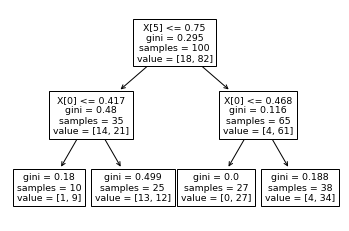

In [ ]:
from sklearn import tree
tree.plot_tree(model)

[Text(0.5, 0.8333333333333334, 'X[0] <= 0.368\ngini = 0.497\nsamples = 770\nvalue = [354, 416]'),
 Text(0.25, 0.5, 'X[8] <= 0.007\ngini = 0.496\nsamples = 579\nvalue = [314, 265]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.488\nsamples = 524\nvalue = [303, 221]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.32\nsamples = 55\nvalue = [11, 44]'),
 Text(0.75, 0.5, 'X[8] <= 0.001\ngini = 0.331\nsamples = 191\nvalue = [40, 151]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.424\nsamples = 128\nvalue = [39, 89]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.031\nsamples = 63\nvalue = [1, 62]')]

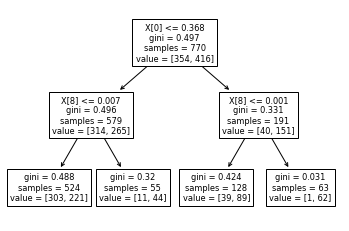

In [ ]:
tree.plot_tree(model2)

In [ ]:
# Neural Network
from sklearn.neural_network import MLPClassifier

# hepatitis
nn = MLPClassifier(hidden_layer_sizes=(100,))
nn.fit(x_train_hpt, y_train_hpt)
y_pred_hpt = nn.predict(x_test_hpt)
acc_hpt,recall_hpt,precision_hpt,Selectivity_hpt,N_predictive_v_hpt = accuracy(x_test_hpt, y_test_hpt, y_pred_hpt)
print(f'NN accuracy for hepatitis is {acc_hpt*100:.1f}.')
print(f'NN recall for hepatitis is {recall_hpt*100:.1f}.')
print(f'NN precision for hepatitis is {precision_hpt*100:.1f}.')
print(f'NN Selectivity for hepatitis is {Selectivity_hpt*100:.1f}.')
print(f'NN Negative predictive value for hepatitis is {N_predictive_v_hpt*100:.1f}.')

print()

# diabetes
nn2 = MLPClassifier(hidden_layer_sizes=(100,))
nn2.fit(x_train_dbt, y_train_dbt)
y_pred_dbt = nn2.predict(x_test_dbt)
acc_dbt,recall_dbt,precision_dbt,Selectivity_dbt,N_predictive_v_dbt = accuracy(x_test_dbt, y_test_dbt, y_pred_dbt)
print(f'NN accuracy for diabetes is {acc_dbt*100:.1f}.')
print(f'NN recall for diabetes is {recall_dbt*100:.1f}.')
print(f'NN precision for diabetes is {precision_dbt*100:.1f}.')
print(f'NN Selectivity for diabetes is {Selectivity_dbt*100:.1f}.')
print(f'NN Negative predictive value for diabetes is {N_predictive_v_dbt*100:.1f}.')


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


NN accuracy for hepatitis is 81.4.
NN recall for hepatitis is 100.0.
NN precision for hepatitis is 81.4.
NN Selectivity for hepatitis is 0.0.
NN Negative predictive value for hepatitis is 0.0.

NN accuracy for diabetes is 69.0.
NN recall for diabetes is 62.1.
NN precision for diabetes is 73.8.
NN Selectivity for diabetes is 76.4.
NN Negative predictive value for diabetes is 65.3.


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


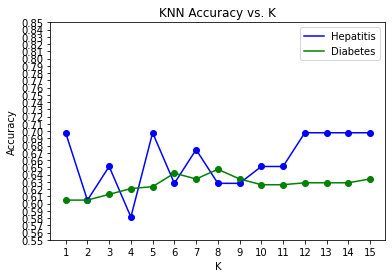

In [ ]:
plt.scatter(knn_k, knn_acc_hpt, color="blue")
plt.plot(knn_k, knn_acc_hpt, color="blue", label="Hepatitis")

plt.scatter(knn_k, knn_acc_dbt, color="green")
plt.plot(knn_k, knn_acc_dbt, color="green", label="Diabetes")

plt.xlabel("K")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1,16))
plt.yticks(np.arange(0.55, 0.86, 0.01))
plt.title("KNN Accuracy vs. K")
plt.legend()

0.6551724137931034


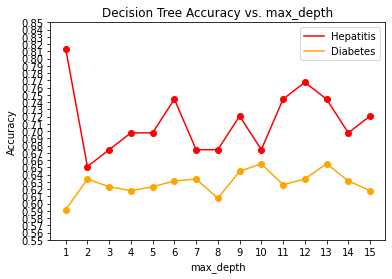

In [ ]:
plt.scatter(dt_depth, dt_acc_hpt, color="red")
plt.plot(dt_depth, dt_acc_hpt, color="red", label="Hepatitis")

plt.scatter(dt_depth, dt_acc_dbt, color="orange")
plt.plot(dt_depth, dt_acc_dbt, color="orange", label="Diabetes")


plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1,16))
plt.yticks(np.arange(0.55, 0.86, 0.01))
plt.title("Decision Tree Accuracy vs. max_depth")
plt.legend()

print(np.max(dt_acc_dbt))